# Create Figures

# Objective

Create figures examining trends of NFIP claims in New York City.

In [1]:
# import libraries
from datetime import datetime
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# reproducibility
%reload_ext watermark
%watermark -v -p duckdb,pandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb    : 1.0.0
pandas    : 1.5.1
matplotlib: 3.6.2
seaborn   : 0.12.1



In [3]:
current_date = datetime.now()
print(f"This notebook was executed on {current_date.strftime('%Y-%m-%d')}.")

This notebook was executed on 2025-03-25.


# Getting Started: OpenFEMA
- [OpenFEMA](https://www.fema.gov/about/reports-and-data/openfema): The public’s resource for FEMA program data. Promoting a culture of Open Government and increasing transparency, participation, and collaboration among the Whole Community in support of FEMA's mission to help people before, during, and after disasters.


- [OpenFEMA Developer Resources](https://www.fema.gov/about/openfema/developer-resources): Welcome to the OpenFEMA Developer Resources page, devoted to providing additional development information regarding our Application Programming Interface (API) for use in your applications and mashups.  The API is free of charge and does not currently have user registration requirements.


- [OpenFEMA API Documentation](https://www.fema.gov/about/openfema/api): As part of the OpenFEMA initiative, FEMA is providing read-only API based access to datasets (Entities). The data is exposed using a RESTful interface that uses query string parameters to manage the query. Use of the service is free and does not require a subscription or API key.


- [OpenFEMA Terms and Conditions](https://www.fema.gov/about/openfema/terms-conditions): Respect the OpenFEMA API and content on this website. Use the Site in a lawful manner. Do not modify the Site or attempt to use it to publish or transmit malicious software or content. FEMA shall not be liable for any damages resulting from the use of this website, API services, or content. Do not attempt to reidentify the individuals whose data may be aggregated. We may suspend your access to this website if we feel you have not complied with these terms and conditions..

# OpenFEMA Dataset: FIMA NFIP Redacted Claims - v2

[OpenFEMA Dataset: FIMA NFIP Redacted Claims - v2](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2): Congress passed the National Flood Insurance Act (NFIA), 42 U.S.C. 4001 in 1968, creating the National Flood Insurance Program (NFIP) in order to reduce future flood losses through flood hazard identification, floodplain management, and providing insurance protection. This dataset provides details on NFIP claims transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information.

In [4]:
# create a DuckDB database instance
con = duckdb.connect()

# create the 'claims' table from Parquet file
con.execute("""
    CREATE TABLE claims AS
    SELECT *
    FROM read_parquet('data/nfip-claims-nyc.parquet')
""")

# create the 'policies' table from Parquet file
con.execute("""
    CREATE TABLE policies AS
    SELECT *
    FROM read_parquet('data/nfip-policies-nyc.parquet')
""")

# show tables
con.execute("SHOW TABLES").fetchall()

[('claims',), ('policies',)]

In [5]:
# sanity check, count claims
sql = """
    SELECT COUNT(*) AS count
    FROM claims
"""

con.sql(sql)

┌───────┐
│ count │
│ int64 │
├───────┤
│ 43978 │
└───────┘

In [6]:
# sanity check, count policies
sql = """
    SELECT COUNT(*) AS count
    FROM policies
"""

con.sql(sql)

┌────────┐
│ count  │
│ int64  │
├────────┤
│ 548267 │
└────────┘

In [7]:
# sanity check, claims preview
sql = """
    SELECT *
    FROM claims
    LIMIT 5
"""

con.sql(sql)

┌──────────────────────┬──────────────────────┬──────────────────────┬───┬──────────┬───────────┬──────────────────────┐
│ agricultureStructu…  │       asOfDate       │ basementEnclosureC…  │ … │ latitude │ longitude │          id          │
│       boolean        │       varchar        │        int64         │   │  double  │  double   │         uuid         │
├──────────────────────┼──────────────────────┼──────────────────────┼───┼──────────┼───────────┼──────────────────────┤
│ false                │ 2020-09-10T19:02:5…  │                    1 │ … │     40.8 │     -73.8 │ 80349555-9429-4ec2…  │
│ false                │ 2024-09-23T14:02:0…  │                    1 │ … │     40.9 │     -73.8 │ e1d4d5a4-c438-4ef1…  │
│ false                │ 2020-01-22T16:55:5…  │                    2 │ … │     40.8 │     -73.9 │ c9b02a95-815a-4c69…  │
│ false                │ 2020-01-22T16:55:5…  │                    2 │ … │     40.8 │     -73.9 │ c43c75c0-9add-4c96…  │
│ false                │ 2020-01

In [8]:
# sanity check, policies preview
sql = """
    SELECT *
    FROM policies
    LIMIT 5
"""

con.sql(sql)

┌──────────────────────┬────────────────────┬──────────────────────┬───┬──────────┬───────────┬──────────────────────┐
│ agricultureStructu…  │ baseFloodElevation │ basementEnclosureC…  │ … │ latitude │ longitude │          id          │
│       boolean        │       double       │        int64         │   │  double  │  double   │         uuid         │
├──────────────────────┼────────────────────┼──────────────────────┼───┼──────────┼───────────┼──────────────────────┤
│ false                │               13.0 │                    0 │ … │     40.8 │     -73.8 │ c4b3dc22-1f60-4d08…  │
│ false                │               NULL │                 NULL │ … │     40.9 │     -73.8 │ e4f4f206-5a14-46e9…  │
│ false                │               NULL │                    1 │ … │     40.8 │     -73.9 │ 93f58e3e-f563-4587…  │
│ false                │               NULL │                    2 │ … │     40.8 │     -73.8 │ d4a416b2-f4ad-4cfb…  │
│ false                │               NULL │   

# Explore Claims Dataset

In [9]:
sql = """
    SELECT
        column_name,
        column_type
    FROM
        (DESCRIBE claims)
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────────┬─────────────┐
│                column_name                 │ column_type │
│                  varchar                   │   varchar   │
├────────────────────────────────────────────┼─────────────┤
│ agricultureStructureIndicator              │ BOOLEAN     │
│ asOfDate                                   │ VARCHAR     │
│ basementEnclosureCrawlspaceType            │ BIGINT      │
│ policyCount                                │ BIGINT      │
│ crsClassificationCode                      │ BIGINT      │
│ dateOfLoss                                 │ VARCHAR     │
│ elevatedBuildingIndicator                  │ BOOLEAN     │
│ elevationCertificateIndicator              │ VARCHAR     │
│ elevationDifference                        │ BIGINT      │
│ baseFloodElevation                         │ DOUBLE      │
│ ratedFloodZone                             │ VARCHAR     │
│ houseWorship                               │ BOOLEAN     │
│ locationOfContents    

In [10]:
sql = """
    SELECT
        column_name,
        null_percentage
    FROM
        (SUMMARIZE FROM claims)
    WHERE
        null_percentage > 0
    ORDER BY
        null_percentage DESC
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────────┬─────────────────┐
│                column_name                 │ null_percentage │
│                  varchar                   │  decimal(9,2)   │
├────────────────────────────────────────────┼─────────────────┤
│ crsClassificationCode                      │          100.00 │
│ floodCharacteristicsIndicator              │           99.70 │
│ eventDesignationNumber                     │           97.31 │
│ lowestAdjacentGrade                        │           87.20 │
│ lowestFloorElevation                       │           86.93 │
│ baseFloodElevation                         │           86.62 │
│ elevationDifference                        │           86.50 │
│ nonPaymentReasonBuilding                   │           80.12 │
│ nonPaymentReasonContents                   │           74.26 │
│ nfipCommunityNumberCurrent                 │           73.34 │
│ floodZoneCurrent                           │           73.34 │
│ nfipCommunityName      

In [11]:
sql = """
    WITH date_columns AS (
        SELECT
            column_name,
            column_type
        FROM
            (DESCRIBE claims)
    )
    
    SELECT *
    FROM date_columns 
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────────┬─────────────┐
│                column_name                 │ column_type │
│                  varchar                   │   varchar   │
├────────────────────────────────────────────┼─────────────┤
│ agricultureStructureIndicator              │ BOOLEAN     │
│ asOfDate                                   │ VARCHAR     │
│ basementEnclosureCrawlspaceType            │ BIGINT      │
│ policyCount                                │ BIGINT      │
│ crsClassificationCode                      │ BIGINT      │
│ dateOfLoss                                 │ VARCHAR     │
│ elevatedBuildingIndicator                  │ BOOLEAN     │
│ elevationCertificateIndicator              │ VARCHAR     │
│ elevationDifference                        │ BIGINT      │
│ baseFloodElevation                         │ DOUBLE      │
│ ratedFloodZone                             │ VARCHAR     │
│ houseWorship                               │ BOOLEAN     │
│ locationOfContents    

In [12]:
sql = """
    WITH date_columns AS (
        SELECT
            dateOfLoss,
            originalConstructionDate,
            originalNBDate
        FROM
            claims
    )  
    SELECT * FROM (SUMMARIZE date_columns)
"""

con.sql(sql).to_df()

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,dateOfLoss,VARCHAR,1978-01-01T00:00:00.000Z,2025-03-02T00:00:00.000Z,2544,NaN,NaN,NaN,NaN,NaN,43978,0.00
1,originalConstructionDate,VARCHAR,1492-10-12T00:00:00.000Z,2022-06-24T00:00:00.000Z,4798,NaN,NaN,NaN,NaN,NaN,43978,0.01
2,originalNBDate,VARCHAR,1975-09-06T00:00:00.000Z,2024-09-25T00:00:00.000Z,10909,NaN,NaN,NaN,NaN,NaN,43978,0.00


# Data Cleaning
Replace construction date before 1652 as null. Oldest buildings in NYC: https://en.wikipedia.org/wiki/List_of_the_oldest_buildings_in_New_York

In [13]:
sql = """
    WITH date_columns AS (
        SELECT
            dateOfLoss,
            originalConstructionDate,
            originalNBDate
        FROM
            claims
    )  
    SELECT column_name, min, max FROM (SUMMARIZE date_columns)
"""

con.sql(sql).to_df()

,column_name,min,max
0,dateOfLoss,1978-01-01T00:00:00.000Z,2025-03-02T00:00:00.000Z
1,originalConstructionDate,1492-10-12T00:00:00.000Z,2022-06-24T00:00:00.000Z
2,originalNBDate,1975-09-06T00:00:00.000Z,2024-09-25T00:00:00.000Z


In [14]:
sql = """
    UPDATE claims
        SET
            originalConstructionDate = NULL
        WHERE
            strftime('%Y', CAST(originalConstructionDate AS TIMESTAMP)) < '1652'
"""

con.sql(sql)

In [15]:
# format date columns
sql = """
    UPDATE claims
        SET
            dateOfLoss = strftime('%Y-%m-%d', CAST(dateOfLoss AS TIMESTAMP)),
            originalConstructionDate = strftime('%Y-%m-%d', CAST(originalConstructionDate AS TIMESTAMP)),
            originalNBDate = strftime('%Y-%m-%d', CAST(originalNBDate AS TIMESTAMP))
"""
con.sql(sql)

In [16]:
# sanity check
sql = """
    WITH date_columns AS (
        SELECT
            dateOfLoss,
            originalConstructionDate,
            originalNBDate
        FROM
            claims
    )  
    SELECT column_name, min, max FROM (SUMMARIZE date_columns)
"""

con.sql(sql).to_df()

,column_name,min,max
0,dateOfLoss,1978-01-01,2025-03-02
1,originalConstructionDate,1860-05-01,2022-06-24
2,originalNBDate,1975-09-06,2024-09-25


# Tables and Figures

In [17]:
sql = """
    SELECT
        COUNT(*) AS count,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)) / 1_000_000, 3) AS total_amount_paidM,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::INT AS average_amount_paid 
    FROM
        claims
"""

df = con.sql(sql).to_df()

print(df.shape)
df

(1, 3)


,count,total_amount_paidM,average_amount_paid
0,43978,1463.057,33268


NYC County FIPS codes:  
- The Bronx is Bronx County (FIPS 36005)  
- Brooklyn is Kings County (FIPS 36047)  
- Manhattan is New York County (FIPS 36061)  
- Queens is Queens County (FIPS 36081)  
- Staten Island is Richmond County (FIPS 36085)

In [18]:
sql = """
    SELECT
        countyCode,                                                      
        COUNT(*) AS count,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)) / 1_000_000, 3) AS total_amount_paidM,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::INT AS average_amount_paid 
    FROM
        claims
    GROUP BY
        countyCode 
    ORDER BY
        total_amount_paidM DESC 
"""

df = con.sql(sql).to_df()

print(df.shape)
df

(5, 4)


,countyCode,count,total_amount_paidM,average_amount_paid
0,36081,14873,704.901,47395
1,36047,6264,328.603,52459
2,36085,19414,281.761,14513
3,36061,1485,120.391,81071
4,36005,1942,27.401,14110


In [19]:
sql = """
    SELECT
        floodEvent,
        yearOfLoss,
        COUNT(*) AS count,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)) / 1_000_000, 3) AS total_amount_paidM,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::INT AS average_amount_paid 
    FROM
        claims
    WHERE
        floodEvent NOT NULL
    GROUP BY
        floodEvent, yearOfLoss
    ORDER BY
        total_amount_paidM DESC
    LIMIT
        15
"""

df = con.sql(sql).to_df()

print(df.shape)
df

(15, 5)


,floodEvent,yearOfLoss,count,total_amount_paidM,average_amount_paid
0,Hurricane Sandy,2012,16504,1296.569,78561
1,Hurricane Ida,2021,1115,29.974,26882
2,Hurricane Irene,2011,2322,22.690,9772
3,December Storm - Nor'easter,1992,1916,18.052,9422
4,Late-September New York Flooding,2023,449,9.123,20318
5,Not a named storm,1979,2305,6.186,2684
6,Nor'easter,2010,371,2.689,7248
7,Mid-spring storms,2014,176,2.672,15181
8,Flooding,1996,257,2.174,8457
9,Late summer storms,2011,347,2.017,5812


In [20]:
sql = """
    SELECT
        yearOfLoss,
        COUNT(*) AS count,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS total_claim,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)) / 1_000_000, 3) AS total_claimM,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::INT AS average_claim 
    FROM
        claims
    WHERE
        yearOfLoss != 2025  
    GROUP BY
        yearOfLoss
    ORDER BY
        total_claim DESC       
"""

df = con.sql(sql).to_df()
print(df.shape)

(47, 5)


In [21]:
top_ten = (
    df
    .sort_values(by='total_claim', ascending=False)
    .head(10)
    .assign(rank=range(1, 11))
)

cols = [
    'rank', 'yearOfLoss',
    'count', 'total_claim', 'total_claimM', 'average_claim'
]

top_ten = top_ten.loc[:, cols]

top_ten

,rank,yearOfLoss,count,total_claim,total_claimM,average_claim
0,1,2012,16656,1299373061,1299.373,78012
1,2,2021,1295,31821958,31.822,24573
2,3,2011,2771,24945672,24.946,9002
3,4,1992,1964,18375480,18.375,9356
4,5,1979,4693,12781324,12.781,2723
5,6,2023,592,11620002,11.620,19628
6,7,2022,531,11535189,11.535,21724
7,8,1980,4171,7723211,7.723,1852
8,9,1978,2498,6634539,6.635,2656
9,10,1996,488,4828953,4.829,9895


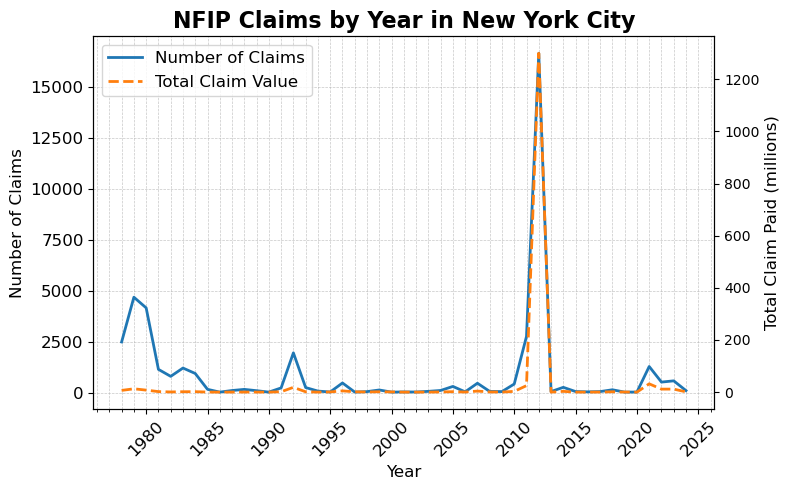

In [22]:
# create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot the number of claims (count_year) on the first axis with a thicker line
sns.lineplot(
    data=df,
    x='yearOfLoss',
    y='count',
    ax=ax1,
    color='C0',
    linewidth=2,  # thicker line for better visibility
    label='Number of Claims'  # add a label for the legend
)

# create a second y-axis for the amount paid (total_claim)
ax2 = ax1.twinx()

# plot the total claim amount (total_claim) on the second axis with a different line style
sns.lineplot(
    data=df,
    x='yearOfLoss',
    y='total_claimM',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  # Dashed line for differentiation
    label='Total Claim Value'
)

# set the title and labels with clear and concise text
ax1.set_title('NFIP Claims by Year in New York City', fontsize=16, weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Claims', fontsize=12)
ax2.set_ylabel('Total Claim Paid (millions)', fontsize=12)

# set the x-axis major and minor ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# improve tick label formatting
ax1.tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# combine the legends from both axes and put them in the upper left
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine the handles and labels from both axes
ax1.legend(handles + handles2, labels + labels2, loc='upper left', fontsize=12)
ax2.legend().set_visible(False)

# tight layout to adjust spacing
plt.tight_layout()

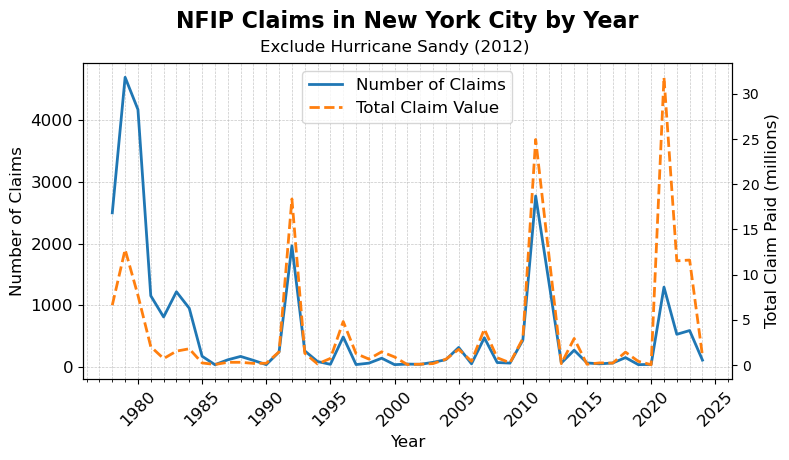

In [23]:
# create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot the number of claims (count_year) on the first axis with a thicker line
sns.lineplot(
    data=df.loc[df['yearOfLoss'] != 2012],
    x='yearOfLoss',
    y='count',
    ax=ax1,
    color='C0',
    linewidth=2,  # thicker line for better visibility
    label='Number of Claims',  # add a label for the legend
)

# create a second y-axis for the amount paid (total_claim)
ax2 = ax1.twinx()

# plot the total claim amount (total_claim) on the second axis with a different line style
sns.lineplot(
    data=df.loc[df['yearOfLoss'] != 2012],
    x='yearOfLoss',
    y='total_claimM',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  # Dashed line for differentiation
    label='Total Claim Value'
)

# set the title and labels with clear and concise text
ax1.set_title('NFIP Claims in New York City by Year\n', fontsize=16, weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Claims', fontsize=12)
ax2.set_ylabel('Total Claim Paid (millions)', fontsize=12)

# set the x-axis major and minor ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# improve tick label formatting
ax1.tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# combine the legends from both axes and put them in the upper left
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine the handles and labels from both axes
ax1.legend(handles + handles2, labels + labels2, loc='upper center', fontsize=12)
ax2.legend().set_visible(False)

plt.suptitle('Exclude Hurricane Sandy (2012)', y=.85)

# tight layout to adjust spacing
plt.tight_layout()

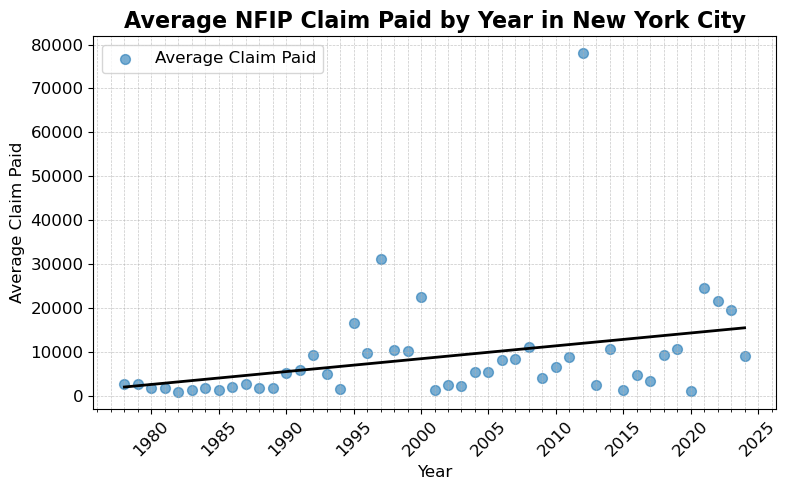

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))

# plot the number of claims (average_claim) with a regression line
sns.regplot(
    data=df,
    x='yearOfLoss',
    y='average_claim',
    ax=ax,
    color='C0',
    scatter_kws={'s': 50, 'alpha': 0.6},  # adjust scatter point size and transparency
    line_kws={'color': 'black', 'linewidth': 2},  # make the regression line black and thicker
    label='Average Claim Paid',  # properly label the regression line
    ci=None  # remove confidence interval shading for cleaner presentation
)

# set the title and labels with clear and concise text
ax.set_title('Average NFIP Claim Paid by Year in New York City', fontsize=16, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average Claim Paid', fontsize=12)

# set the x-axis major and minor ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# improve tick label formatting
ax.tick_params(axis='x', rotation=45)  # rotate x-ticks for better readability
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# add the legend
ax.legend(loc='upper left', fontsize=12)

# tight layout to adjust spacing
plt.tight_layout()

# Explore Policies Dataset

In [25]:
# sanity check
sql = """
    SELECT COUNT(*) AS count
    FROM policies
"""

con.sql(sql)

┌────────┐
│ count  │
│ int64  │
├────────┤
│ 548267 │
└────────┘

In [26]:
# sanity check
sql = """
    SELECT
        column_name,
        column_type
    FROM
        (DESCRIBE policies)
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────┬─────────────┐
│              column_name               │ column_type │
│                varchar                 │   varchar   │
├────────────────────────────────────────┼─────────────┤
│ agricultureStructureIndicator          │ BOOLEAN     │
│ baseFloodElevation                     │ DOUBLE      │
│ basementEnclosureCrawlspaceType        │ BIGINT      │
│ cancellationDateOfFloodPolicy          │ VARCHAR     │
│ condominiumCoverageTypeCode            │ VARCHAR     │
│ construction                           │ BOOLEAN     │
│ crsClassCode                           │ BIGINT      │
│ buildingDeductibleCode                 │ VARCHAR     │
│ contentsDeductibleCode                 │ VARCHAR     │
│ elevatedBuildingIndicator              │ BOOLEAN     │
│ elevationCertificateIndicator          │ VARCHAR     │
│ elevationDifference                    │ BIGINT      │
│ federalPolicyFee                       │ BIGINT      │
│ ratedFloodZone               

In [27]:
# sanity check
sql = """
    SELECT
        column_name,
        null_percentage
    FROM
        (SUMMARIZE FROM policies)
    WHERE
        null_percentage > 0
    ORDER BY
        null_percentage DESC
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────┬─────────────────┐
│              column_name               │ null_percentage │
│                varchar                 │  decimal(9,2)   │
├────────────────────────────────────────┼─────────────────┤
│ crsClassCode                           │          100.00 │
│ cancellationDateOfFloodPolicy          │           97.35 │
│ cancellationVoidanceReasonCode         │           97.35 │
│ obstructionType                        │           87.74 │
│ lowestAdjacentGrade                    │           78.12 │
│ baseFloodElevation                     │           78.06 │
│ lowestFloorElevation                   │           78.06 │
│ elevationDifference                    │           77.99 │
│ propertyPurchaseDate                   │           67.29 │
│ elevationCertificateIndicator          │           64.63 │
│ enclosureTypeCode                      │           63.03 │
│ insuranceToValueCode                   │           53.61 │
│ premiumPaymentIndicato

In [28]:
sql = """
    SELECT
        strftime('%Y', CAST(policyEffectiveDate AS TIMESTAMP))::INT AS policyEffectiveYear,
        SUM(policyCount)::BIGINT AS policyCount
    FROM
        policies 
    WHERE     
        policyEffectiveYear != '2025'
    GROUP BY
        policyEffectiveYear
    ORDER BY
        policyEffectiveYear      
"""

df = con.sql(sql).to_df()
print(df.shape)
df

(16, 2)


,policyEffectiveYear,policyCount
0,2009,37540
1,2010,38143
2,2011,39857
3,2012,41368
4,2013,56771
5,2014,56947
6,2015,57275
7,2016,57238
8,2017,55890
9,2018,54878


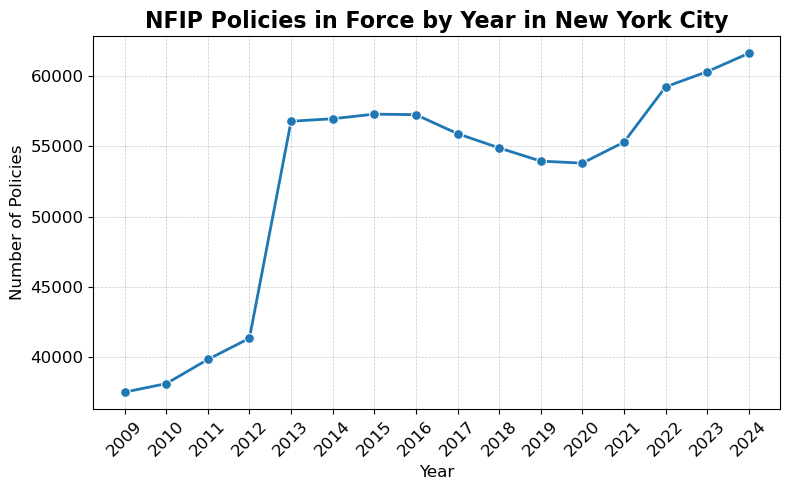

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=df,
    x='policyEffectiveYear',
    y='policyCount',
    ax=ax,
    color='C0',
    linewidth=2,  
    marker='o',  
    markersize=7,  
    linestyle='-',  
)

ax.set_title('NFIP Policies in Force by Year in New York City', fontsize=16, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Policies', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator())  

ax.tick_params(axis='x', rotation=45)  
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()

In [30]:
sql = """
    SELECT
        yearOfLoss,
        COUNT(*) AS count
    FROM
        claims
    WHERE
        yearOfLoss != 2025  
        AND yearOfLoss >= 2009
    GROUP BY
        yearOfLoss
    ORDER BY
        yearOfLoss      
"""

claims_df = con.sql(sql).to_df()
print(claims_df.shape)

claims_df.head()

(16, 2)


,yearOfLoss,count
0,2009,65
1,2010,437
2,2011,2771
3,2012,16656
4,2013,67


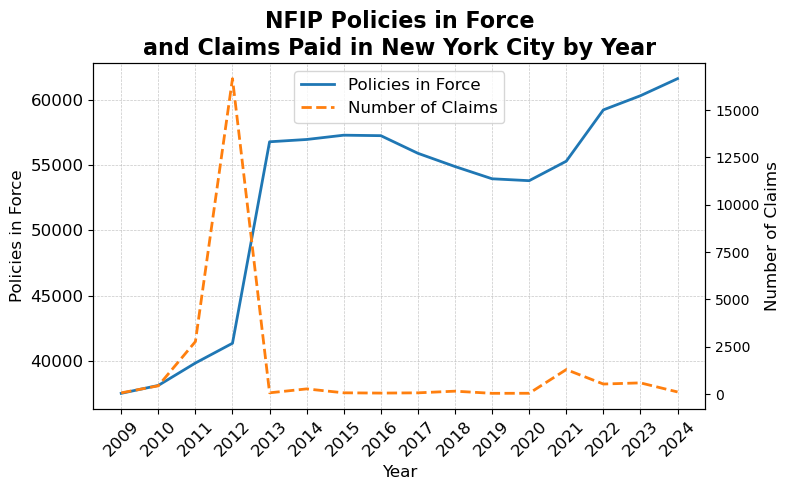

In [31]:
# create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot the number of claims (count_year) on the first axis with a thicker line
sns.lineplot(
    data=df,
    x='policyEffectiveYear',
    y='policyCount',
    ax=ax1,
    color='C0',
    linewidth=2,  # thicker line for better visibility
    label='Policies in Force',  # add a label for the legend
)

# create a second y-axis for the amount paid (total_claim)
ax2 = ax1.twinx()

# plot the total claim amount (total_claim) on the second axis with a different line style
sns.lineplot(
    data=claims_df,
    x='yearOfLoss',
    y='count',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  # Dashed line for differentiation
    label='Number of Claims'
)

# set the title and labels with clear and concise text
ax1.set_title('NFIP Policies in Force\nand Claims Paid in New York City by Year', fontsize=16, weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Policies in Force', fontsize=12)
ax2.set_ylabel('Number of Claims', fontsize=12)

# set the x-axis major and minor ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator())

# improve tick label formatting
ax1.tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability
ax1.tick_params(axis='both', which='major', labelsize=12)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# combine the legends from both axes and put them in the upper left
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine the handles and labels from both axes
ax1.legend(handles + handles2, labels + labels2, loc='upper center', fontsize=12, facecolor='white')
ax2.legend().set_visible(False)

# tight layout to adjust spacing
plt.tight_layout()

In [32]:
merged_df = claims_df.merge(
    df,
    left_on='yearOfLoss',
    right_on='policyEffectiveYear'
)

merged_df['claims_pif'] = merged_df['count'] / merged_df['policyCount']

merged_df.head()

,yearOfLoss,count,policyEffectiveYear,policyCount,claims_pif
0,2009,65,2009,37540,0.001731
1,2010,437,2010,38143,0.011457
2,2011,2771,2011,39857,0.069524
3,2012,16656,2012,41368,0.402630
4,2013,67,2013,56771,0.001180


In [33]:
merged_df['claims_pif'].describe()

count    16.000000
mean      0.033938
std       0.099805
min       0.000742
25%       0.001178
50%       0.002320
75%       0.010228
max       0.402630
Name: claims_pif, dtype: float64

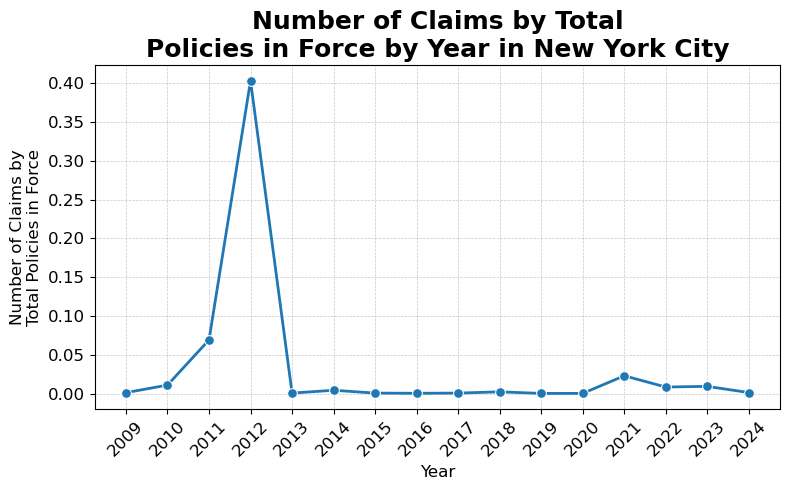

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=merged_df,
    x='policyEffectiveYear',
    y='claims_pif',
    ax=ax,
    color='C0',
    linewidth=2,  
    marker='o',  
    markersize=7,  
    linestyle='-',  
)

ax.set_title(
    'Number of Claims by Total\nPolicies in Force by Year in New York City', 
    fontsize=18, 
    weight='bold'
)
ax.set_xlabel('Year', fontsize=12)  
ax.set_ylabel('Number of Claims by\nTotal Policies in Force', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.tick_params(axis='x', rotation=45)  
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()